In [2]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, LinearRegression
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV


In [3]:
path_u = os.path.abspath("usersData.csv")
path_f = os.path.abspath("followers_views.csv")
path_l = os.path.abspath("likes_views.csv")
user = pd.read_csv(path_u)
follower = pd.read_csv(path_f)
likes = pd.read_csv(path_l)
del path_u, path_f, path_l

In [4]:
user["likes*followers"] = np.sqrt(user['avg_likes']*user["avg_followers"])
user["followers/post"] = user["avg_followers"] / user["avg_posts"]
user["comments/likes"] = user["avg_comments"] / user["avg_likes"]
user["focus dif"] = user["max_likes"] - user["min_likes"]
user["focus ratio"] = user["max_likes"] / user["min_likes"]
print(user.shape)
user.head()

(114781, 12)


,avg_likes,avg_comments,avg_followers,avg_posts,max_likes,min_likes,avg_views,likes*followers,followers/post,comments/likes,focus dif,focus ratio
0,97.50,3.00,13178.0,1967.0,113,59,333.1667,1133.514446,6.699542,0.030769,54,1.915254
1,91.75,9.25,4228.0,1402.0,174,39,308.6250,622.831438,3.015692,0.100817,135,4.461538
2,33.00,3.50,2212.0,2471.0,46,23,126.7500,270.177719,0.895184,0.106061,23,2.000000
3,20.00,3.50,203.0,1838.0,26,16,65.5000,63.718129,0.110446,0.175000,10,1.625000
4,13.20,1.20,132.0,309.0,18,9,61.2000,41.742065,0.427184,0.090909,9,2.000000


In [4]:
print(follower.shape)
follower.head()

(1422894, 2)


,followers,views
0,13178,250
1,13178,604
2,13178,239
3,13178,858
4,13178,271


In [5]:
print(likes.shape)
likes.head()

(1426188, 2)


,likes,views
0,98,250
1,100,604
2,109,239
3,103,858
4,106,271


#### Create graphs 

Mean views: 745.0688204134606


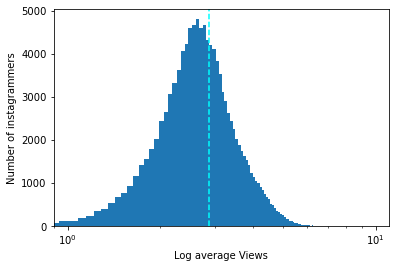

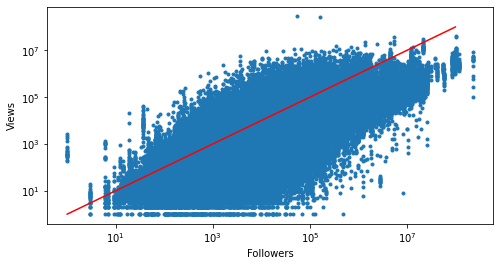

Text(0, 0.5, 'Views')

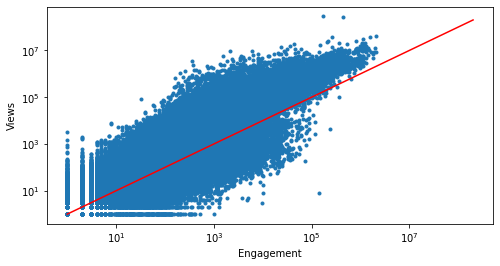

In [6]:
views_log = np.log10(user["avg_views"])
print("Mean views: {}".format(10**(views_log.mean())))
plt.hist(views_log,bins=100)
plt.axvline(x=views_log.mean(),linestyle='--',color='cyan')
plt.xscale("log")
plt.xlim(left=0.9,right=11)
plt.xlabel("Log average Views")
plt.ylabel("Number of instagrammers")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(follower["followers"],follower["views"],".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Followers")
plt.ylabel("Views")
plt.plot([1,10**8],[1,10**8],"r-")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(likes["likes"],likes["views"],".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Engagement")
plt.plot([1,2*10**8],[1,2*10**8],"r-")
plt.ylabel("Views")

#https://stackoverflow.com/questions/46415327/matplotlib-plot-points-look-fuzzy-in-python-sharp-in-ipython

#### Merging will be hard, followers are not unique 

In [7]:
follower[follower['followers']== 13178].head(11)

,followers,views
0,13178,250
1,13178,604
2,13178,239
3,13178,858
4,13178,271
5,13178,317
6,13178,318
7,13178,126
136754,13178,1629
136755,13178,1866


#### Transform "likes" and "followers" using log scale , drop inf 

In [5]:
user_scaled = user.copy()
user_scaled.loc(1)["avg_likes"] = user["avg_likes"] / np.log(user["avg_likes"])
user_scaled.loc(1)["avg_followers"] = user["avg_followers"] / np.log(user["avg_followers"])
user_scaled = user_scaled.loc[user_scaled["avg_likes"] != np.inf,:]

x_full_unscaled, y_full_unscaled = user.drop("avg_views",1), user["avg_views"]
x_full, y_full = user_scaled.drop("avg_views",1), user_scaled["avg_views"]

Baselines

In [6]:

lin = LinearRegression()

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)

#follower baseline
n_scores = cross_val_score(lin, user_scaled["avg_followers"].values.reshape(-1, 1), y_full, scoring='r2', cv=cv, n_jobs=-1)
print('R2 follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

#like baseline
n_scores = cross_val_score(lin, user_scaled["avg_likes"].values.reshape(-1, 1), y_full, scoring='r2', cv=cv, n_jobs=-1)
print('R2 like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 follower baseline: 0.136 (0.413)
R2 like baseline: 0.676 (0.077)


Applying RFE, no need for different seeds just increase n_repeats

In [12]:
rfe = RFECV(estimator=RandomForestRegressor())
forest = RandomForestRegressor()
pipeline_forest = Pipeline(steps=[('feature selection',rfe),('model',forest)])

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
n_scores = cross_val_score(pipeline_forest, x_full, y_full, scoring='r2', cv=cv, n_jobs=None)

print('R2 Randomforest reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Randomforest reduced: 0.637 (0.112)


In [11]:
rfe_r = RFECV(estimator=Ridge())
ridge = Ridge()
pipeline_ridge = Pipeline(steps=[('feature selection',rfe_r),('model',ridge)])

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
n_scores = cross_val_score(pipeline_ridge, x_full, y_full, scoring='r2', cv=cv, n_jobs=None)

print('R2 Ridge reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Ridge reduced: 0.603 (0.209)


#### Using "avg_views" as the variable to predict

Random Forest unscaled

In [13]:
forest = RandomForestRegressor()
scores = cross_val_score(forest, x_full, y_full, scoring='r2', cv=5)
print("CV R2 score: {}".format(scores.mean()))
scores


CV R2 score: 0.5977448647705879


array([0.60305927, 0.31575175, 0.73631195, 0.65415852, 0.67944284])

Random Forest scaled 

In [14]:
x_full, y_full = user_scaled.drop("avg_views",1), user_scaled["avg_views"]
forest = RandomForestRegressor()
scores = cross_val_score(forest, x_full, y_full, scoring='r2', cv=5)
print("CV R2 score: {}".format(scores.mean()))
scores


CV R2 score: 0.5715642010048162


array([0.58984397, 0.19917776, 0.74477864, 0.65222915, 0.67179149])

Ridge scaled

In [15]:
ridge = Ridge()
scores = cross_val_score(ridge, x_full, y_full, scoring='r2', cv=5)
print("CV R2 score: {}".format(scores.mean()))
scores


CV R2 score: 0.6176009849044936


array([0.64787687, 0.50037248, 0.61071777, 0.65533374, 0.67370406])

Removing **users** with "followers/post" or "comments/likes" outside of 2 std deviations

In [ ]:
removed_outliers = user_scaled[(abs(zscore(user_scaled['followers/post'])) < 2) & (abs(zscore(user_scaled['comments/likes'])) < 2 )]

views_log = np.log10(removed_outliers["avg_views"])
print("Mean views: {} \nMean views in the paper: 748".format(10**(views_log.mean())))
plt.hist(views_log,bins=100)
plt.axvline(x=views_log.mean(),linestyle='--',color='cyan')
plt.xscale("log")
plt.xlim(left=0.9,right=11)
plt.xlabel("Log average Views")
plt.ylabel("Number of instagrammers")
plt.show()

In [16]:
path_l = os.path.abspath
path_l

<function ntpath.abspath(path)>

In [17]:
user_scaled.isna().sum()

avg_likes          0
avg_comments       0
avg_followers      0
avg_posts          0
max_likes          0
min_likes          0
avg_views          0
likes*followers    0
followers/post     0
comments/likes     0
focus dif          0
focus ratio        0
dtype: int64